In [ ]:
import os

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

In [ ]:
np.random.seed(12049)

In [ ]:
def get_classes(data_path, classes, data):
    print(f"---- {data} ----")
    knee_severity = {}
    count = 0

    for i in range(len(classes)):
        imgs = os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i] = imgs
        count += len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k} - {classes[k]}: {len(v)} images, {round((len(v) * 100) / count, 2)}%"
        )

    return knee_severity


def compute_confusion_matrix(
    predictions, valid_generator, class_names, model_name
):
    cm = confusion_matrix(
        y_true=valid_generator.labels,
        y_pred=np.argmax(predictions, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))


def make_gradcam_heatmap(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(
        superimposed_img
    )

    return superimposed_img

In [ ]:
import os
os.environ["KAGGLE_USERNAME"]="kurumaddaliadithya"
os.environ["KAGGLE_KEY"]="069a49573a3a1b3859643bc315c5adee"



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!kaggle datasets download shashwatwork/knee-osteoarthritis-dataset-with-severity

 99% 202M/204M [00:11<00:00, 23.1MB/s]
100% 204M/204M [00:11<00:00, 18.7MB/s]


In [ ]:
!unzip knee-osteoarthritis-dataset-with-severity.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/0/9684605R.png    
  inflating: train/0/9685238L.png    
  inflating: train/0/9685238R.png    
  inflating: train/0/9686617L.png    
  inflating: train/0/9686617R.png    
  inflating: train/0/9686777R.png    
  inflating: train/0/9686834L.png    
  inflating: train/0/9686834R.png    
  inflating: train/0/9686908L.png    
  inflating: train/0/9686908R.png    
  inflating: train/0/9687273L.png    
  inflating: train/0/9689906R.png    
  inflating: train/0/9690910L.png    
  inflating: train/0/9690910R.png    
  inflating: train/0/9691359L.png    
  inflating: train/0/9691359R.png    
  inflating: train/0/9692163L.png    
  inflating: train/0/9692604L.png    
  inflating: train/0/9692604R.png    
  inflating: train/0/9692923R.png    
  inflating: train/0/9693364R.png    
  inflating: train/0/9693599L.png    
  inflating: train/0/9693599R.png    
  inflating: train/0/9694101L.png    
  inflating: train/0/9694101R.png    

In [ ]:

test_path = os.path.join('/content/test')

class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

tests_data = get_classes(test_path, class_names, 'test')

---- test ----
Grade 0 - Healthy: 639 images, 38.59%
Grade 1 - Doubtful: 296 images, 17.87%
Grade 2 - Minimal: 447 images, 26.99%
Grade 3 - Moderate: 223 images, 13.47%
Grade 4 - Severe: 51 images, 3.08%


In [ ]:
model_name = "Xception"
batch_size = 256
target_size = (224, 224)

In [ ]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

In [ ]:
test_generator = noaug_datagen.flow_from_directory(
    test_path,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 1656 images belonging to 5 classes.


In [ ]:
y_test = test_generator.labels

In [ ]:
xception = tf.keras.models.load_model('/content/drive/MyDrive/model_Xception_ft.hdf5')

In [ ]:
predictions_xception = xception.predict(test_generator)
score_xception = xception.evaluate(test_generator, verbose=1)
print('Test loss:', score_xception[0])
print('Test acc:', score_xception[1])

7/7 [==============================] - 8s 881ms/step - loss: 0.8618 - accuracy: 0.6165
Test loss: 0.8617674112319946
Test acc: 0.6165459156036377


In [ ]:
get_metrics(
    test_generator.labels,
    y_pred=np.argmax(predictions_xception, axis=1),
    model_name=model_name,
)

Accuracy Score - Xception: 0.62
Balanced Accuracy Score - Xception: 0.67


              precision    recall  f1-score   support

           0       0.82      0.60      0.69       639
           1       0.31      0.46      0.37       296
           2       0.65      0.66      0.66       447
           3       0.73      0.71      0.72       223
           4       0.59      0.92      0.72        51

    accuracy                           0.62      1656
   macro avg       0.62      0.67      0.63      1656
weighted avg       0.66      0.62      0.63      1656



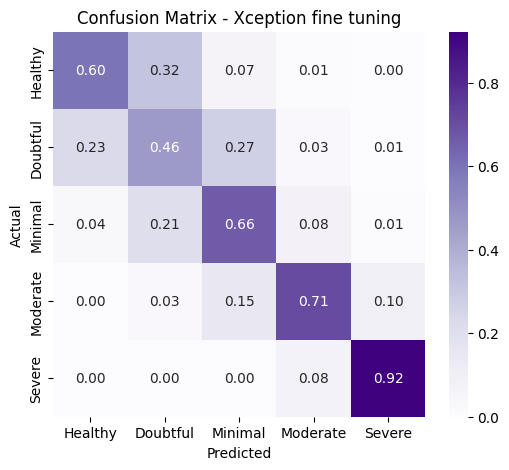

In [ ]:
compute_confusion_matrix(
    predictions_xception,
    test_generator,
    class_names,
    f"{model_name} fine tuning",
)

In [ ]:
xception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 20871725 (79.62 MB)
Trainable params: 20817197 (79.41 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [ ]:
# Last layer
conv_output = xception.get_layer("global_average_pooling2d_1").input

grad_model = tf.keras.models.Model(
    [xception.inputs], [conv_output, xception.output]
)

# model
xception.layers[-1].activation = None

Test data - Healthy


<ipython-input-3-24d0ce795dd4>:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


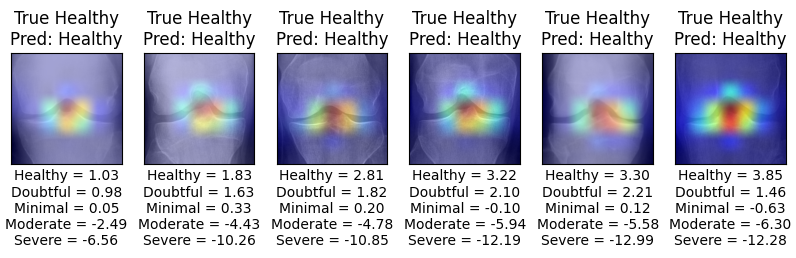

Test data - Doubtful


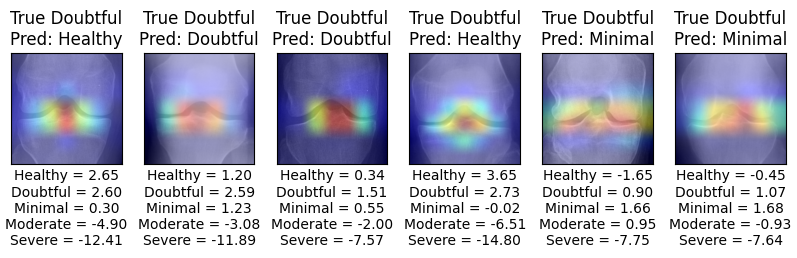

Test data - Minimal


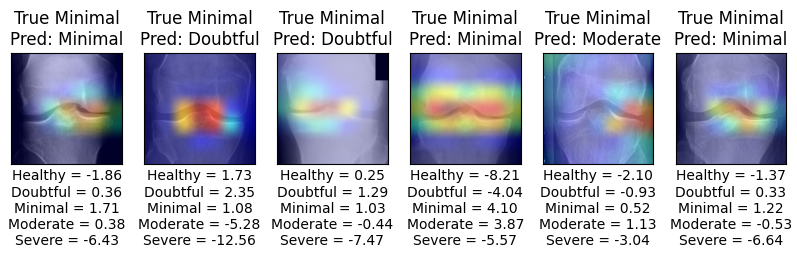

Test data - Moderate


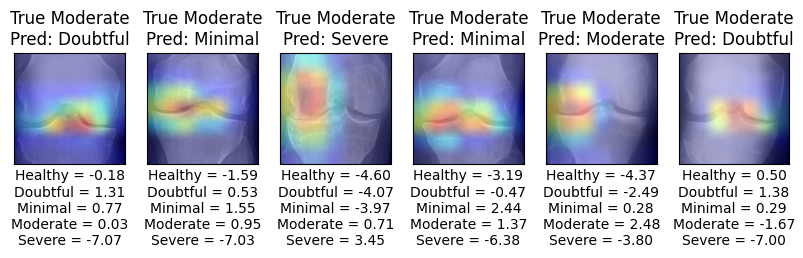

Test data - Severe


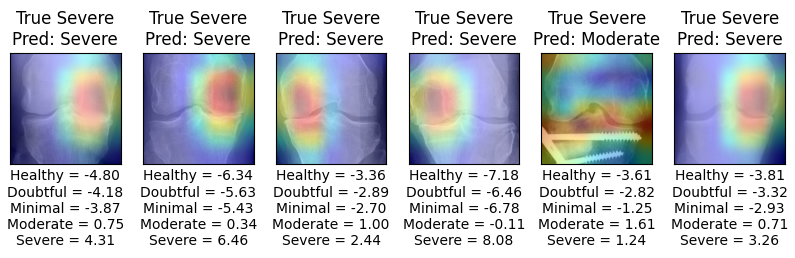

In [ ]:
for k, v in tests_data.items():
    print(f"Test data - {class_names[k]}")
    plt.figure(figsize=(10, 28))
    for i in range(6):
        img_path = os.path.join(test_path, str(k), v[i])
        # prepare image
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=target_size
        )
        img = tf.keras.preprocessing.image.img_to_array(img)

        img_aux = img.copy()
        img_array = np.expand_dims(img_aux, axis=0)
        img_array = np.float32(img_array)
        img_array = tf.keras.applications.xception.preprocess_input(img_array)

        y_pred = xception.predict(img_array, verbose=0)[0]

        heatmap = make_gradcam_heatmap(grad_model, img_array)
        image = save_and_display_gradcam(img, heatmap)

        plt.subplot(1, 6, 1 + i, xticks=[], yticks=[])
        plt.imshow(image)
        plt.title(
            f"True {class_names[k]}\nPred: {class_names[np.argmax(y_pred)]}"
        )
        plt.xlabel(
            "\n".join([f"{c} = {p:.2f}" for c, p in zip(class_names, y_pred)])
        )
    plt.show()

Streaming output truncated to the last 5000 lines.
  inflating: train/0/9695621L.png    
  inflating: train/0/9695881L.png    
  inflating: train/0/9695881R.png    
  inflating: train/0/9695948L.png    
  inflating: train/0/9695948R.png    
  inflating: train/0/9696350R.png    
  inflating: train/0/9696897L.png    
  inflating: train/0/9696897R.png    
  inflating: train/0/9697904L.png    
  inflating: train/0/9697904R.png    
  inflating: train/0/9699340L.png    
  inflating: train/0/9699340R.png    
  inflating: train/0/9699399L.png    
  inflating: train/0/9699399R.png    
  inflating: train/0/9700163R.png    
  inflating: train/0/9700908L.png    
  inflating: train/0/9700908R.png    
  inflating: train/0/9701362R.png    
  inflating: train/0/9701645L.png    
  inflating: train/0/9701645R.png    
  inflating: train/0/9702644L.png    
  inflating: train/0/9703327L.png    
  inflating: train/0/9703469L.png    
  inflating: train/0/9703469R.png    
  inflating: train/0/9703829L.png    

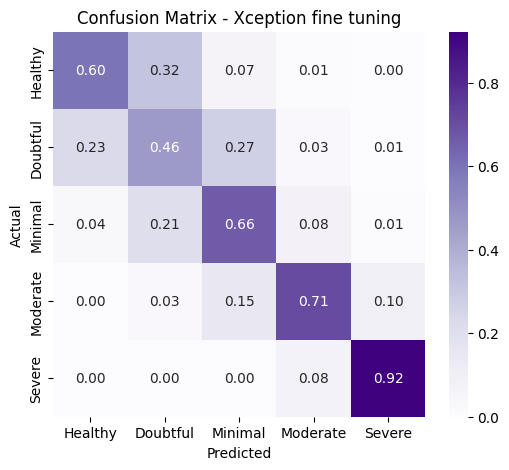

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 20871725 (79.62 MB)
Trainable params: 20817197 (79.41 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


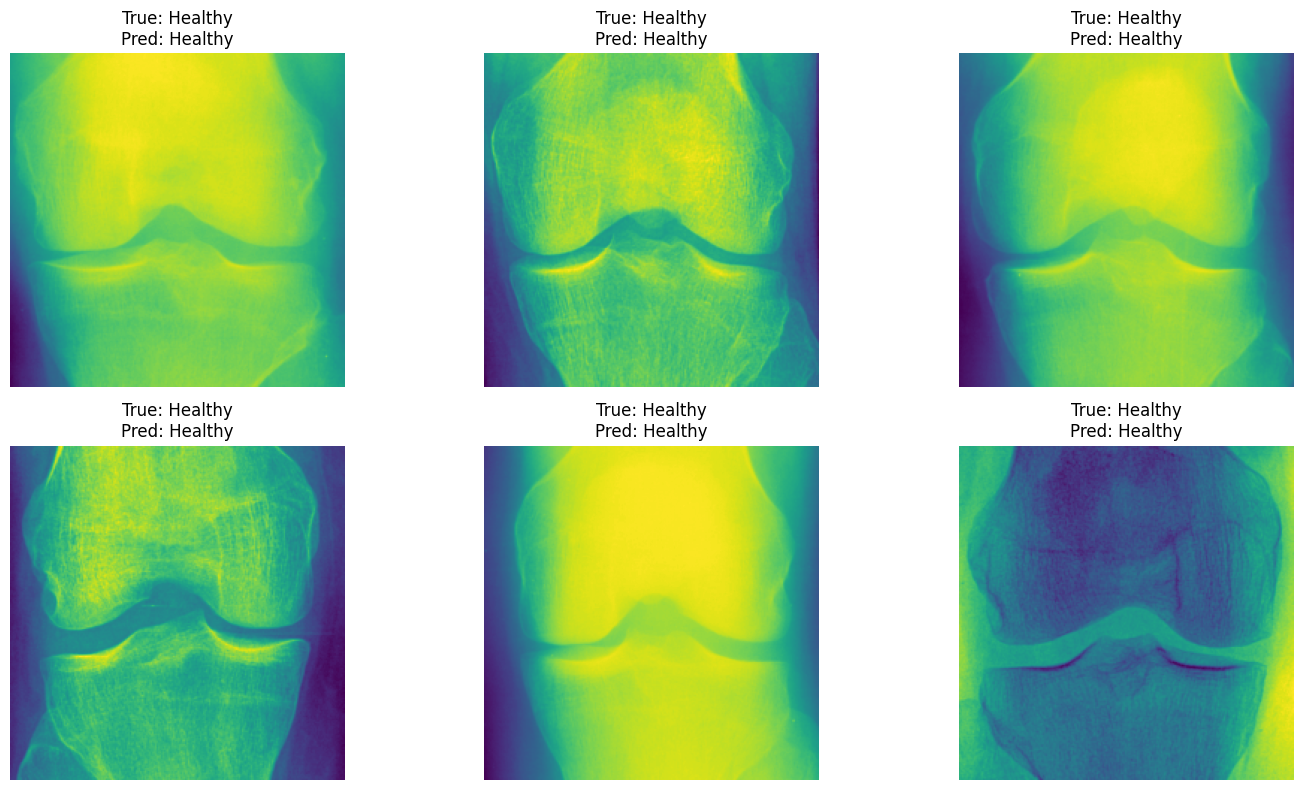

In [4]:
# -*- coding: utf-8 -*-
"""best_model.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1JPnVM4bksy8jodjP3PQcO79MDSB2Bsgy
"""

import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

np.random.seed(12049)

def get_classes(data_path, classes, data):
    print(f"---- {data} ----")
    knee_severity = {}
    count = 0

    for i in range(len(classes)):
        imgs = os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i] = imgs
        count += len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k} - {classes[k]}: {len(v)} images, {round((len(v) * 100) / count, 2)}%"
        )

    return knee_severity


def compute_confusion_matrix(
    predictions, valid_generator, class_names, model_name
):
    cm = confusion_matrix(
        y_true=valid_generator.labels,
        y_pred=np.argmax(predictions, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))


def make_gradcam_heatmap(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap to match image dimensions

    jet_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet_heatmap = cv2.cvtColor(jet_heatmap, cv2.COLOR_BGR2RGB)

    superimposed_img = cv2.addWeighted(img.astype('uint8'), alpha, jet_heatmap, 1 - alpha, 0)

    return superimposed_img


import os
os.environ["KAGGLE_USERNAME"]="kurumaddaliadithya"
os.environ["KAGGLE_KEY"]="069a49573a3a1b3859643bc315c5adee"

from google.colab import drive
drive.mount('/content/gdrive')

!kaggle datasets download shashwatwork/knee-osteoarthritis-dataset-with-severity

!unzip knee-osteoarthritis-dataset-with-severity.zip

test_path = os.path.join('/content/test')

class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

tests_data = get_classes(test_path, class_names, 'test')

model_name = "Xception"
batch_size = 256
target_size = (224, 224)

aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

test_generator = noaug_datagen.flow_from_directory(
    test_path,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

y_test = test_generator.labels

xception = tf.keras.models.load_model('/content/gdrive/MyDrive/model_Xception_ft.hdf5')

predictions_xception = xception.predict(test_generator)
score_xception = xception.evaluate(test_generator, verbose=1)
print('Test loss:', score_xception[0])
print('Test acc:', score_xception[1])

get_metrics(
    test_generator.labels,
    y_pred=np.argmax(predictions_xception, axis=1),
    model_name=model_name,
)

compute_confusion_matrix(
    predictions_xception,
    test_generator,
    class_names,
    f"{model_name} fine tuning",
)

xception.summary()

# Last layer
conv_output = xception.get_layer("global_average_pooling2d_1").input

grad_model = tf.keras.models.Model(
    [xception.inputs], [conv_output, xception.output]
)

# model
xception.layers[-1].activation = None

# Continuation from previous code
correct_predictions = []

for k, v in tests_data.items():
    for img_name in v:
        img_path = os.path.join(test_path, str(k), img_name)
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=target_size
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.xception.preprocess_input(img_array)

        y_pred = xception.predict(img_array, verbose=0)[0]
        pred_class_index = np.argmax(y_pred)

        # Check if the prediction is correct
        if pred_class_index == k:
            correct_predictions.append((img_path, class_names[k], class_names[pred_class_index]))

# Display correct predictions and their corresponding images
plt.figure(figsize=(15, 8))
for i, (img_path, true_class, pred_class) in enumerate(correct_predictions[:6]):
    img = plt.imread(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

np.random.seed(12049)

def get_classes(data_path, classes, data):
    print(f"---- {data} ----")
    knee_severity = {}
    count = 0

    for i in range(len(classes)):
        imgs = os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i] = imgs
        count += len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k} - {classes[k]}: {len(v)} images, {round((len(v) * 100) / count, 2)}%"
        )

    return knee_severity


def compute_confusion_matrix(
    predictions, valid_generator, class_names, model_name
):
    cm = confusion_matrix(
        y_true=valid_generator.labels,
        y_pred=np.argmax(predictions, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))


def make_gradcam_heatmap(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap to match image dimensions

    jet_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet_heatmap = cv2.cvtColor(jet_heatmap, cv2.COLOR_BGR2RGB)

    superimposed_img = cv2.addWeighted(img.astype('uint8'), alpha, jet_heatmap, 1 - alpha, 0)

    return superimposed_img


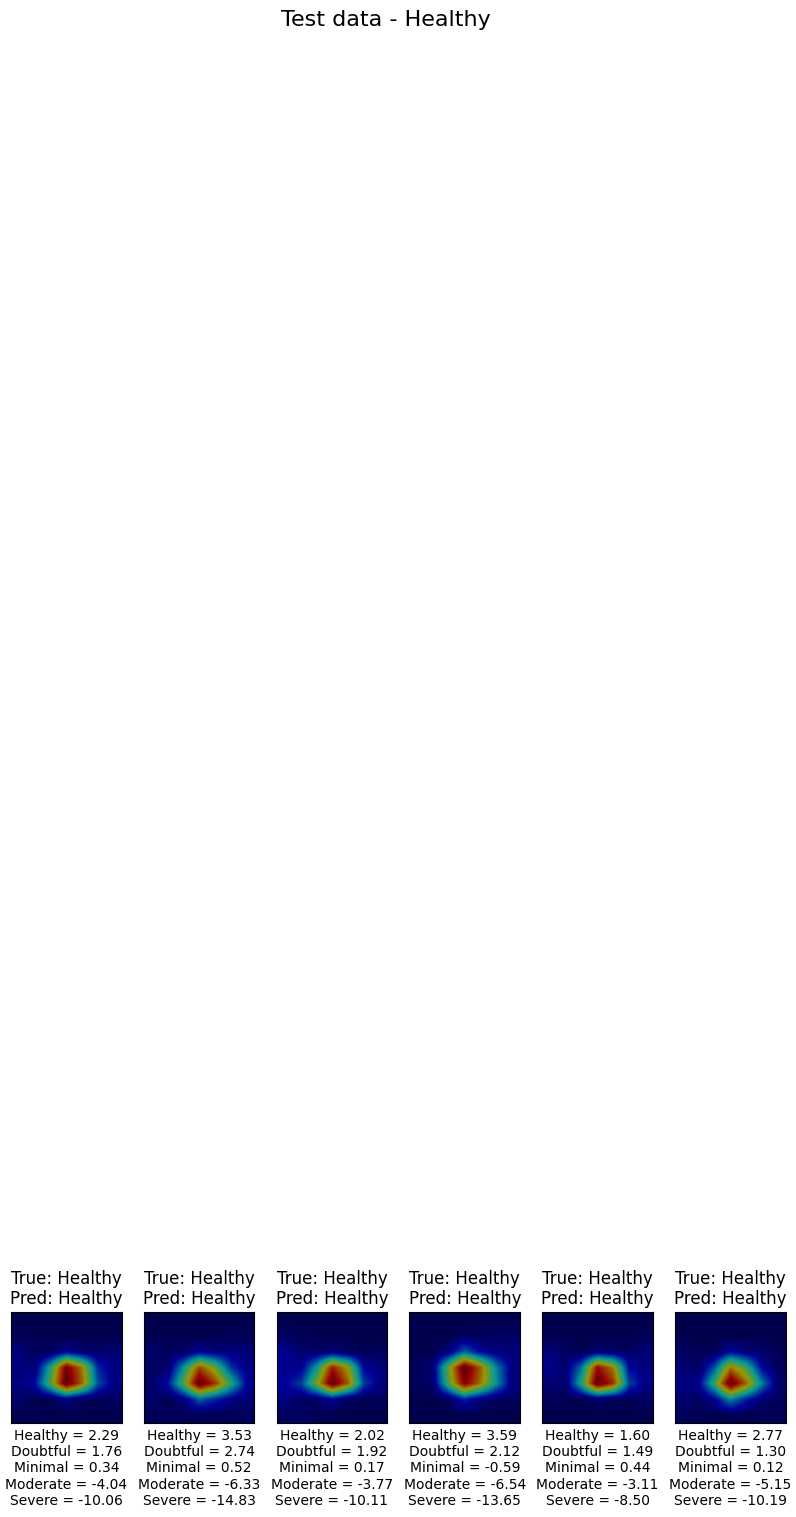

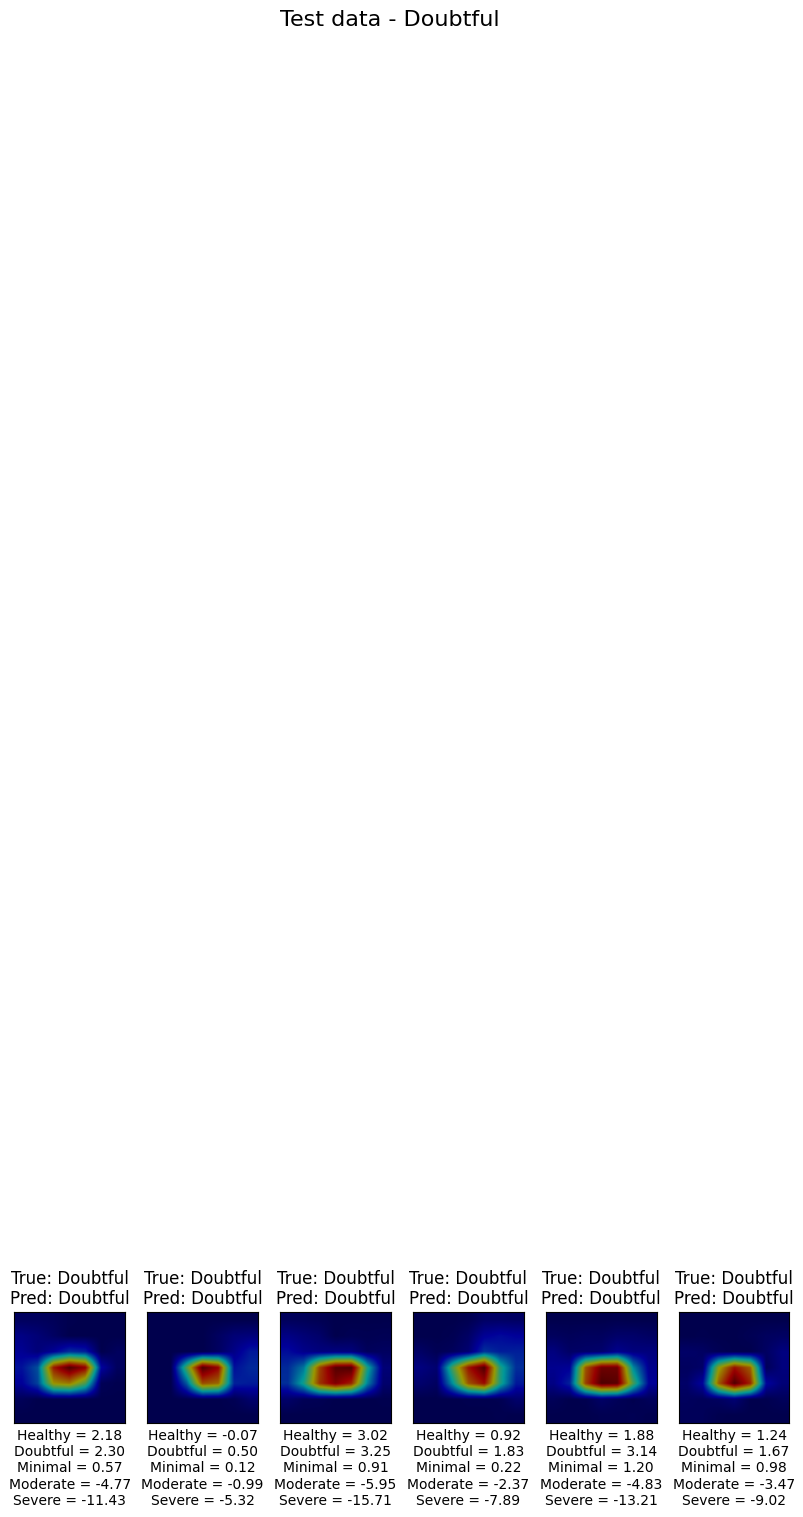

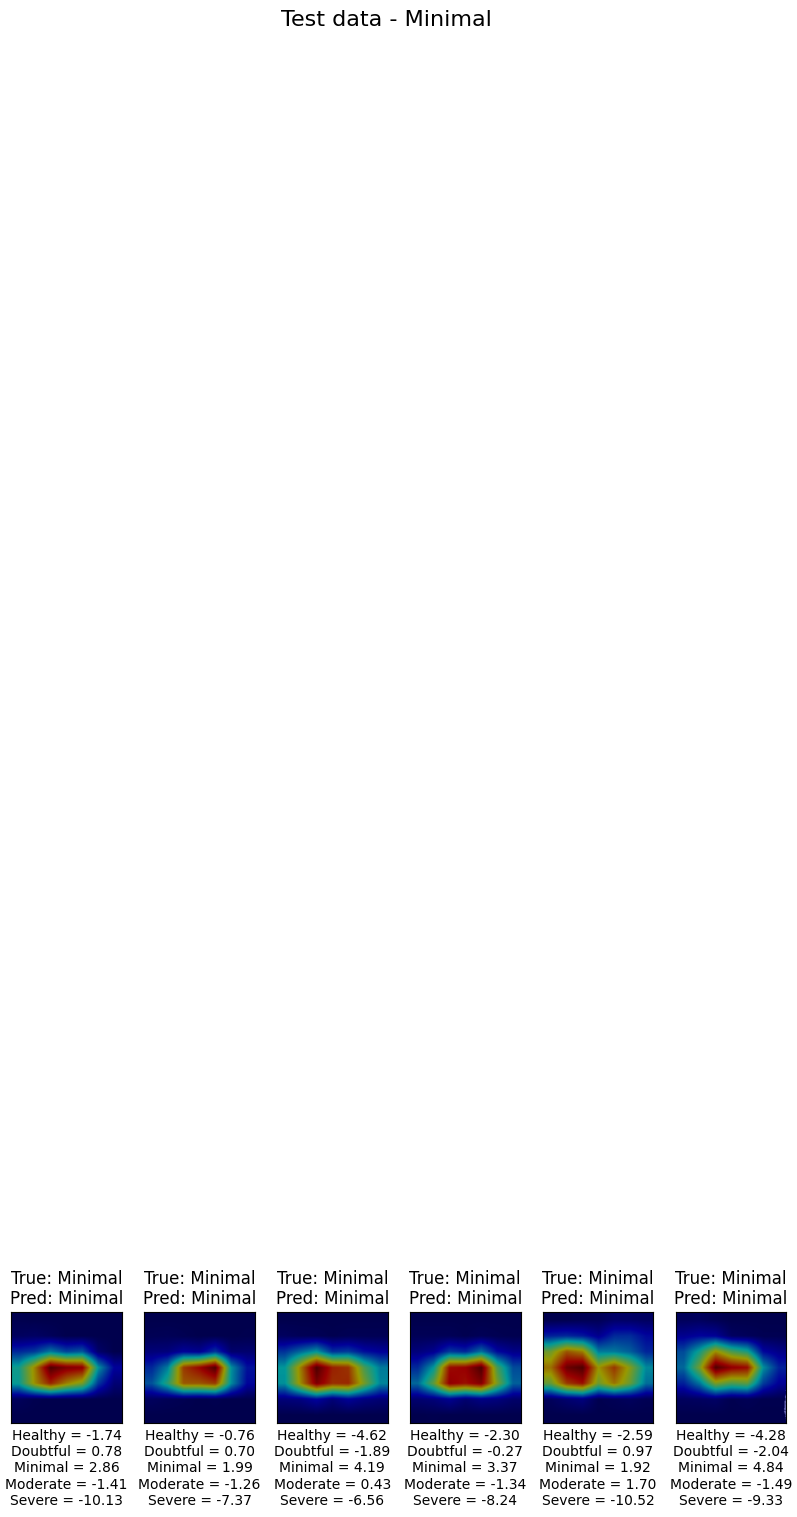

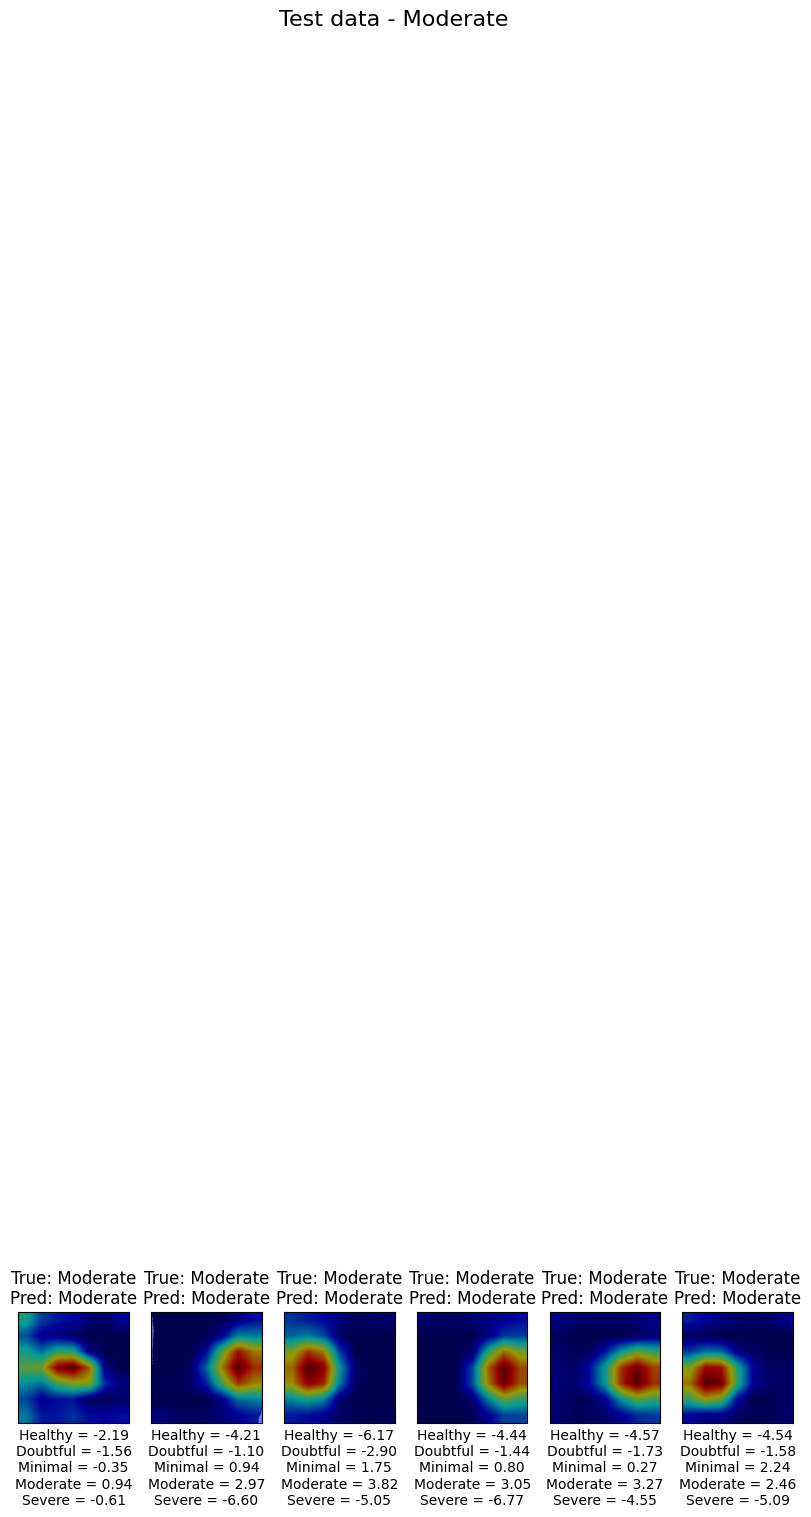

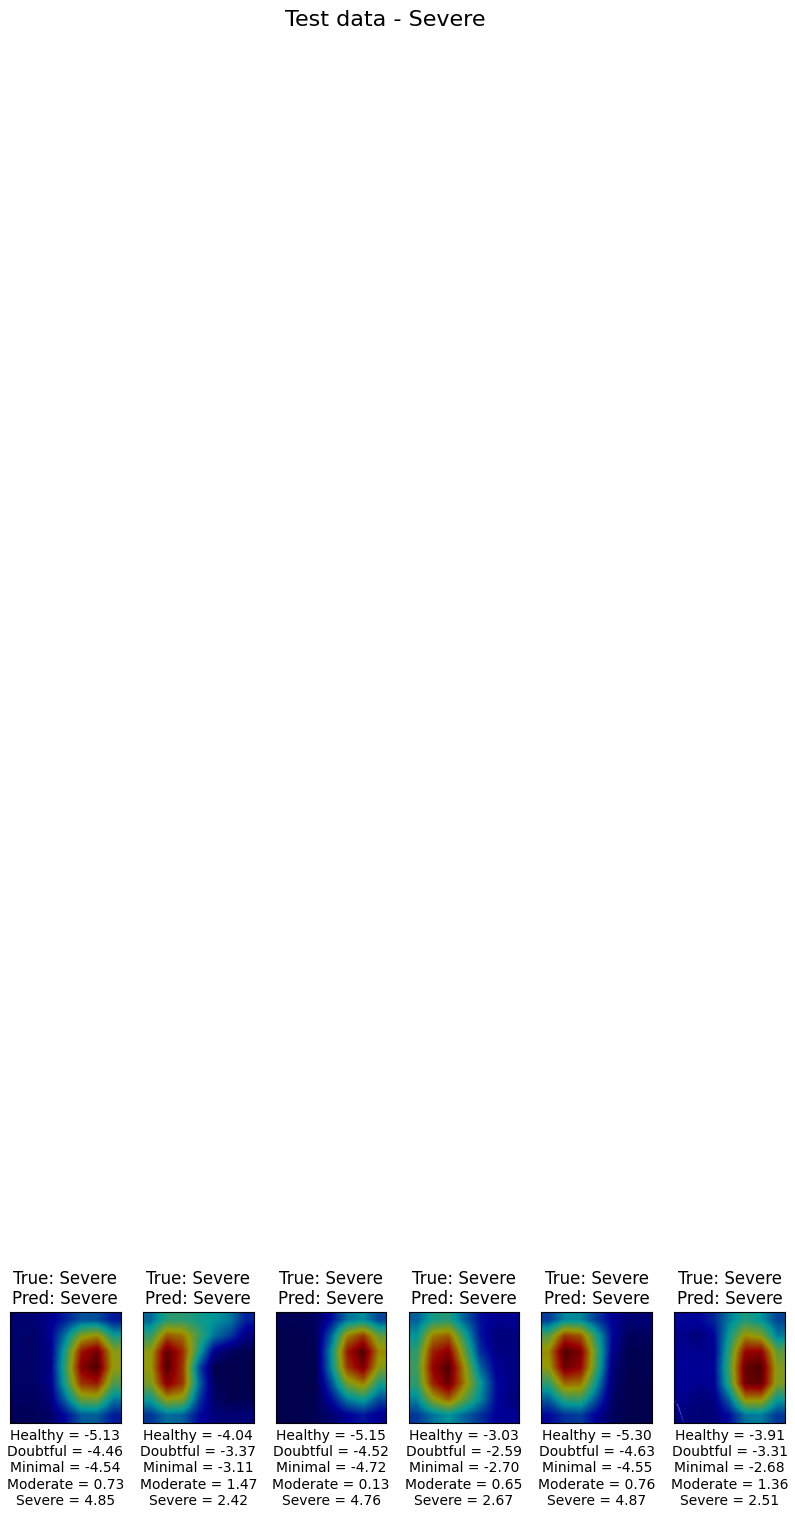

In [10]:
correct_predictions = [[] for _ in range(len(class_names))]

for k, v in tests_data.items():
    for img_name in v:
        img_path = os.path.join(test_path, str(k), img_name)
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=target_size
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.xception.preprocess_input(img_array)

        y_pred = xception.predict(img_array, verbose=0)[0]
        pred_class_index = np.argmax(y_pred)

        # Check if the prediction is correct
        if pred_class_index == k:
            correct_predictions[k].append((img_path, class_names[k], class_names[pred_class_index]))

# Display correct predicted value images only
for k, class_name in enumerate(class_names):
    if len(correct_predictions[k]) == 0:
        continue

    plt.figure(figsize=(10, 28))
    plt.suptitle(f"Test data - {class_name}", fontsize=16)
    for i, (img_path, true_class, pred_class) in enumerate(correct_predictions[k][:6]):
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=target_size
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.xception.preprocess_input(img_array)

        y_pred = xception.predict(img_array, verbose=0)[0]

        heatmap = make_gradcam_heatmap(grad_model, img_array)
        image = save_and_display_gradcam(img_array[0], heatmap)

        plt.subplot(1, 6, 1 + i, xticks=[], yticks=[])
        plt.imshow(image)
        plt.title(
            f"True: {true_class}\nPred: {pred_class}"
        )
        plt.xlabel(
            "\n".join([f"{c} = {p:.2f}" for c, p in zip(class_names, y_pred)])
        )
    plt.show()


In [11]:
# Count correctly predicted images in every stage
correctly_predicted_counts = [len(predictions) for predictions in correct_predictions]

# Print the counts
for stage, count in zip(class_names, correctly_predicted_counts):
    print(f"Correctly predicted images in {stage}: {count}")


Correctly predicted images in Healthy: 382
Correctly predicted images in Doubtful: 137
Correctly predicted images in Minimal: 297
Correctly predicted images in Moderate: 158
Correctly predicted images in Severe: 47


In [12]:
import shutil

# Create a directory to save the images
save_dir = '/content/correctly_predicted_images'
os.makedirs(save_dir, exist_ok=True)

# Save images in separate folders based on stage names
for stage, predictions in zip(class_names, correct_predictions):
    stage_dir = os.path.join(save_dir, stage)
    os.makedirs(stage_dir, exist_ok=True)

    # Copy images to stage directory
    for img_path, _, _ in predictions:
        filename = os.path.basename(img_path)
        shutil.copy(img_path, os.path.join(stage_dir, filename))


In [13]:
import shutil

# Zip the folder
shutil.make_archive('/content/correctly_predicted_images', 'zip', '/content/correctly_predicted_images')

# Download the zip file to your local machine
from google.colab import files
files.download('/content/correctly_predicted_images.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>